# **Sentiment Prediction**

In [2]:
import numpy as np
import pandas as pd
import platform
import configparser
from datetime import datetime, timedelta, date
import glob
import sys
import os
import pickle
import timeit
from tqdm import tqdm

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import model_from_json
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [3]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)

Colab Active:  True


#**Downloads**

In [4]:
if colab_active is True:
  OS = platform.system()      # Operating System

  def data_download(file_to_download, gdrive_code, OS, uncompress = True):
    if not os.path.exists(file_to_download):
      os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
      if OS == "Linux" and uncompress:
          os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
      return True
    else:
      return None

In [5]:
if colab_active is True:
  out = data_download("./Senntiment_Social_Mood_Corpus_Tweets.zip", "11lopgQpkQ-UjwP62icelthzISG_fn2_5", OS)
  out = data_download("./Sentiment_Social_Mood_Models.zip", "1id8az7G6knkXKh7m8ENnKylj_s_W54YN", OS)

In [6]:
with open('./Sentiment_Social_Mood_Models/preprocessed_datasets.pkl', 'rb') as file:
    (x_test, y_test, tokenizer) = pickle.load(file)
    file.close()

## Configs

In [7]:
start_date: date = date(2020,1,1)
end_date  : date = date(2020,5,31)

small_df  : bool = True
small_size: int  = 6000000

max_tokens: int  = 20000
k_model   : str  = 'mod_orig_onestep'

tpu = True
batch_size = 2048

Create a list of dates ranging from `start_date` to `end_date`.

In [8]:
date_list = []

current_date = start_date
iteration = 1

while current_date <= end_date:
    date_list.append(f'{current_date.year}-{current_date.month:02d}-{current_date.day:02d}')
    current_date += timedelta(days=1)
    iteration += 1

## Set the TPU Environment

In [9]:
if tpu is True:
  import tensorflow as tf
  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

  AUTO = tf.data.experimental.AUTOTUNE
  batch_size = batch_size * tpu_strategy.num_replicas_in_sync

Tensorflow version 2.12.0
Running on TPU  ['10.104.170.130:8470']


<hr>

## Data

In [10]:
dfs = []

for date in date_list:
    df_date = pd.read_csv(f'./Senntiment_Social_Mood_Corpus_Tweets/corpus_tweets/{date}.csv', sep=';', encoding='ISO-8859-1')
    dfs.append(df_date)

In [11]:
raw_df = pd.concat(dfs, ignore_index=True)

if small_df is True:
    raw_df = raw_df.sample(small_size)

In [12]:
len(raw_df)

6000000

In [13]:
df = raw_df[['data_tweet', 'testo']]
df['data_tweet'] = pd.to_datetime(df['data_tweet'], format = '%Y%m%d')

<ipython-input-13-2b2346512ad4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_tweet'] = pd.to_datetime(df['data_tweet'], format = '%Y%m%d')


remove tweets that are not type: `str`.

In [14]:
df = df.loc[df['testo'].apply(lambda x: isinstance(x, str))]

## Pre-processing

In [15]:
tweets = np.array(df['testo'])

Transform words into tokens

In [16]:
#tokenizer = Tokenizer(num_words = max_tokens)
#tokenizer.fit_on_texts(tweets)

Transform word sequences into indexed token sequences

In [17]:
sequences = tokenizer.texts_to_sequences(tweets)

<hr>

## Import Model

In [18]:
#model = tf.keras.models.load_model(f'models/{k_model}')
#model = models.load_weights(f'sentiment_bilstm_best.hdf5')
if tpu is True:
  with strategy.scope():
    json_file = open('./Sentiment_Social_Mood_Models/sentiment_bilstm_topology.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("./Sentiment_Social_Mood_Models/sentiment_bilstm_best.hdf5")
else:
  json_file = open('./Sentiment_Social_Mood_Models/sentiment_bilstm_topology.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights("./Sentiment_Social_Mood_Models/sentiment_bilstm_best.hdf5")

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         6248100   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         73984     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                             

In [20]:
del sequences

In [21]:
del tweets

In [22]:
del raw_df

In [23]:
test_tw = pad_sequences(tokenizer.texts_to_sequences(df['testo']), padding = "pre")

In [24]:
len(test_tw)

5999814

## Predictions

In [25]:
# Prediction of The Model
pred_test = model.predict(x_test)
pred_test = np.where(pred_test > 0.5, 1, 0)
# Performance of The Model
accuracy_test = accuracy_score(y_test.values, pred_test)
auc_roc_score = roc_auc_score(y_test.values, pred_test)
f1_score_test = f1_score(y_test.values, pred_test)
print('\nAccuracy of The Neural Model on Test Set : ', accuracy_test)
print('ROC AUC Score of The Neural Model on Test Set', auc_roc_score)
print('F1_score of The Neural Model on Test Set : ', f1_score_test)

24/24 [==============================] - 3s 37ms/step

Accuracy of The Neural Model on Test Set :  0.8104575163398693
ROC AUC Score of The Neural Model on Test Set 0.7797582767181531
F1_score of The Neural Model on Test Set :  0.7173489278752437


In [26]:
start_time = timeit.default_timer()
sentiment = model.predict(test_tw, batch_size = batch_size, verbose = 1)
print("Prediction Elapsed Time: ", timeit.default_timer() - start_time)

367/367 [==============================] - 789s 2s/step
Prediction Elapsed Time:  809.3803023100008


In [27]:
predicted_sentiment = [int(i > 0.5) for i in sentiment]
df['predicted_sentiment'] = predicted_sentiment

<ipython-input-27-dd630dee222d>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_sentiment = [int(i > 0.5) for i in sentiment]


In [28]:
len(predicted_sentiment)

5999814

## Build the index

In [29]:
df.set_index('data_tweet', inplace=True)

In [30]:
count_by_day = df.groupby([df.index.date, 'predicted_sentiment']).size()
count_by_day = count_by_day.reset_index()
count_by_day.rename(columns={0: 'count', 'level_0': 'date'}, inplace=True)
pivoted_counts = count_by_day.pivot(index='date', columns='predicted_sentiment', values='count')

In [35]:
index = (pivoted_counts[1] - pivoted_counts[0]) / (pivoted_counts[1] + pivoted_counts[0])

Export results to csv.

In [32]:
index.to_csv(f'predicted_{k_model}.csv', sep = ';', index=True)

In [38]:
index.to_csv(f'predicted_{k_model}.xlsx', sep = ';', index=True)

## Plots

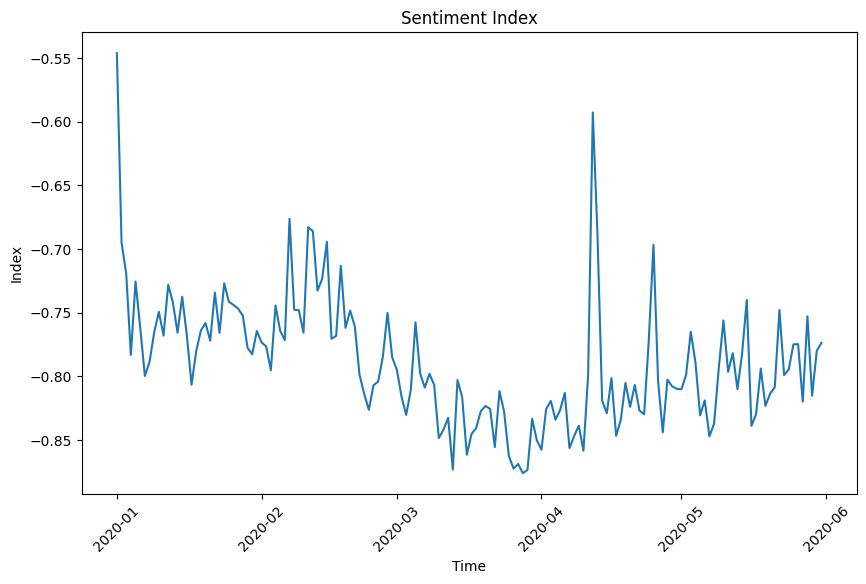

In [37]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pivoted_counts.index, index)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('Sentiment Index')
plt.xticks(rotation=45)
plt.savefig("predicted_mod_orig_onestep.png")

plt.show()

## predictions_2020

In [34]:
with open('predictions_2020.txt', 'r') as file:
    predictions_2020 = file.read()

predictions_2020 = predictions_2020.replace(' ', '').split(',')

FileNotFoundError: ignored

In [ ]:
df['predicted_sentiment'] = predictions_2020[:-1]
df['predicted_sentiment'] = df['predicted_sentiment'].astype(int)

In [ ]:
df.set_index('data_tweet', inplace=True)

In [ ]:
count_by_day = df.groupby([df.index.date, 'predicted_sentiment']).size()
count_by_day = count_by_day.reset_index()
count_by_day.rename(columns={0: 'count', 'level_0': 'date'}, inplace=True)
pivoted_counts = count_by_day.pivot(index='date', columns='predicted_sentiment', values='count')

In [ ]:
index = (pivoted_counts[1] - pivoted_counts[0]) / (pivoted_counts[1] + pivoted_counts[0])

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pivoted_counts.index, index)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('Sentiment Index')
plt.xticks(rotation=45)

plt.show()

In [ ]:
index.to_csv(f'predicted_2020.csv', sep = ';', index=True)